# Rock Classification - 01 Data Cleaning

Data set is from Kaggle's Rock Classification Dataset. This notebook will check the image quality and remove images which are duplicates.

In [7]:
import os
import shutil
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imagehash
from IPython.display import display

## Define and Load the Data Directories

In [8]:
# Directories
original_dir = "./Dataset/"
cleaned_dir = "./Dataset_Cleaned/"

# Clear and create cleaned directory
if os.path.exists(cleaned_dir):
    shutil.rmtree(cleaned_dir)
os.makedirs(cleaned_dir)

# Load data by category
img_data = defaultdict(list)
for category in os.listdir(original_dir):
    category_path = os.path.join(original_dir, category)
    if not os.path.isdir(category_path) or category == '.DS_Store':
        continue
    for subfolder in os.listdir(category_path):
        subfolder_path = os.path.join(category_path, subfolder)
        if not os.path.isdir(subfolder_path) or subfolder == '.DS_Store':
            continue
        files = [
            os.path.join(subfolder_path, img)
            for img in os.listdir(subfolder_path)
            if os.path.isfile(os.path.join(subfolder_path, img)) and img != '.DS_Store'
        ]
        img_data[category].extend(files)

## Image Quality and Duplicated Image Handling

The following code first check if the data is image type, then detects duplicate images using **average hashing (aHash)** from the imagehash library.

**Why use aHash?**

- Fast and efficient for large datasets (with limited GPU).
- Robust to small changes (resizing, minor color differences).
- Lightweight compared to deep learning-based methods.

### Other Duplicate Detection Methods for Exploration:

 **Perceptual Hashing (pHash)**
- Similar to aHash but uses Discrete Cosine Transform (DCT).
- More robust to small image modifications like contrast or brightness changes.

 **Feature-based Methods (ORB, SIFT, SURF)**
- Uses keypoints and descriptors to compare image structures.
- More accurate but computationally expensive.


In [9]:
# Validate and detect duplicates
before_counts = {category: len(paths) for category, paths in img_data.items()}
hash_dict = defaultdict(list)
duplicate_pairs = []

for category, paths in img_data.items():
    for path in paths:
        try:
            with Image.open(path) as img:
                img_hash = imagehash.average_hash(img)
                hash_dict[img_hash].append(path)
        except (IOError, OSError, Image.UnidentifiedImageError) as e:
            print(f"Error: Invalid image {path} - {e}")

# Collect duplicate pairs
for paths in hash_dict.values():
    if len(paths) > 1:
        for i in range(1, len(paths)):
            duplicate_pairs.append((paths[0], paths[i]))

# Compute duplicates per category
duplicate_counts = {}
total_all_images = 0  # Initialize total image counter
for category, paths in img_data.items():
    total = before_counts[category]
    total_all_images += total  # Add to total image count
    dups = sum(1 for path in paths if any(path == dup[1] for dup in duplicate_pairs))
    duplicate_counts[category] = {"total": total, "duplicates": dups}

# Print summary
print(f"Total number of images across all categories: {total_all_images}")
print("\nDuplicate Summary by Category:")
for category, stats in duplicate_counts.items():
    print(f"{category}: {stats['total']} total images, {stats['duplicates']} duplicates")


Total number of images across all categories: 2083

Duplicate Summary by Category:
Metamorphic: 864 total images, 23 duplicates
Sedimentary: 1032 total images, 69 duplicates
Igneous: 187 total images, 5 duplicates


 The result shows:

- **Sedimentary** category has the highest duplicate percentage, which may indicate similar-looking rock images or dataset redundancy.
- **Metamorphic and Igneous rocks** have a lower duplication rate, suggesting better diversity in images.

**Next Steps:** Consider removing duplicate images to ensure a more diverse dataset for training the model and improve model performance by preventing bias towards redundant samples.

## Sample Duplicated Image


First 5 Duplicate Pairs:
Pair 1: 1 (570).jpg | images(18).jpg


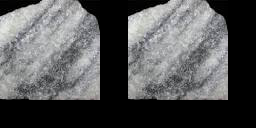

Pair 2: 1 (585).jpg | 31e2cae7a399bd4322fc2f0a8351995e.jpg


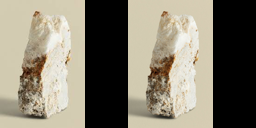

Pair 3: 15169970468_ef3c6b5bff_b.jpg | 1 (592).jpg


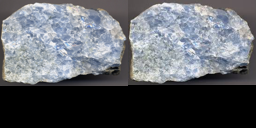

Pair 4: 1 (34).jpg | images(127).jpg


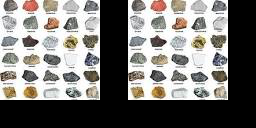

Pair 5: istockphoto-1212981210-612x612.jpg | 161.jpg


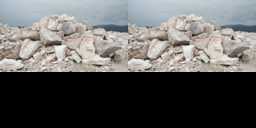

In [10]:
# Display first 5 duplicate pairs
if duplicate_pairs:
    print("\nFirst 5 Duplicate Pairs:")
    for i, (path1, path2) in enumerate(duplicate_pairs[:5], 1):
        img1 = Image.open(path1)
        img2 = Image.open(path2)
        img1.thumbnail((128, 128))
        img2.thumbnail((128, 128))
        combined = Image.new('RGB', (256, 128))
        combined.paste(img1, (0, 0))
        combined.paste(img2, (128, 0))
        print(f"Pair {i}: {os.path.basename(path1)} | {os.path.basename(path2)}")
        display(combined)
        img1.close()
        img2.close()
else:
    print("\nNo duplicates found.")

## Remove Duplicated Image


Total Images Before: 2083
Total Images After: 1986
Duplicates Removed: 97


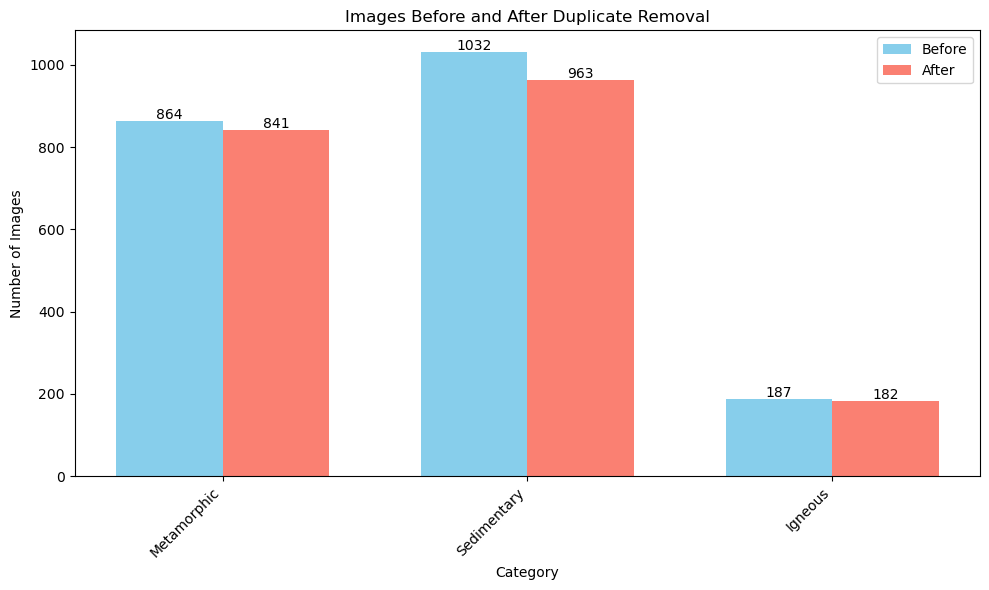

In [11]:
# Remove duplicates and copy unique images
after_counts = {}
kept_paths = {paths[0] for paths in hash_dict.values()}  # Keep first instance of each unique hash

for category, paths in img_data.items():
    for path in paths:
        if path in kept_paths:  # Only copy if it's a kept unique image
            # Extract subcategory from path (e.g., 'Marble' from 'Dataset/Metamorphic/Marble/img.jpg')
            subfolder = os.path.basename(os.path.dirname(path))
            cleaned_subfolder = os.path.join(cleaned_dir, category, subfolder)
            os.makedirs(cleaned_subfolder, exist_ok=True)
            new_path = os.path.join(cleaned_subfolder, os.path.basename(path))
            shutil.copy2(path, new_path)

    # Count unique images per category after copying
    cleaned_category = os.path.join(cleaned_dir, category)
    after_counts[category] = sum(
        len(os.listdir(os.path.join(cleaned_category, subfolder)))
        for subfolder in os.listdir(cleaned_category)
        if os.path.isdir(os.path.join(cleaned_category, subfolder))
    )

# Total summary
total_before = sum(before_counts.values())
total_after = sum(after_counts.values())
print(f"\nTotal Images Before: {total_before}")
print(f"Total Images After: {total_after}")
print(f"Duplicates Removed: {total_before - total_after}")

# Plot bar chart
categories = list(img_data.keys())
before_values = [before_counts[cat] for cat in categories]
after_values = [after_counts[cat] for cat in categories]

x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, before_values, width, label='Before', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After', color='salmon')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Images Before and After Duplicate Removal')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
for i, v in enumerate(before_values):
    plt.text(i - width/2, v + 5, str(v), ha='center')
for i, v in enumerate(after_values):
    plt.text(i + width/2, v + 5, str(v), ha='center')
plt.tight_layout()
plt.show()